In [1]:
import colormaps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/vmeijer/.conda/envs/gspy/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
ordered_true_values = np.load("true_values_figure6.npy")
img = np.load("flight_dists_figure6.npy")

boxes = pd.read_parquet('boxes_figure6.parquet')

In [6]:
plt.rc("font", family="serif")

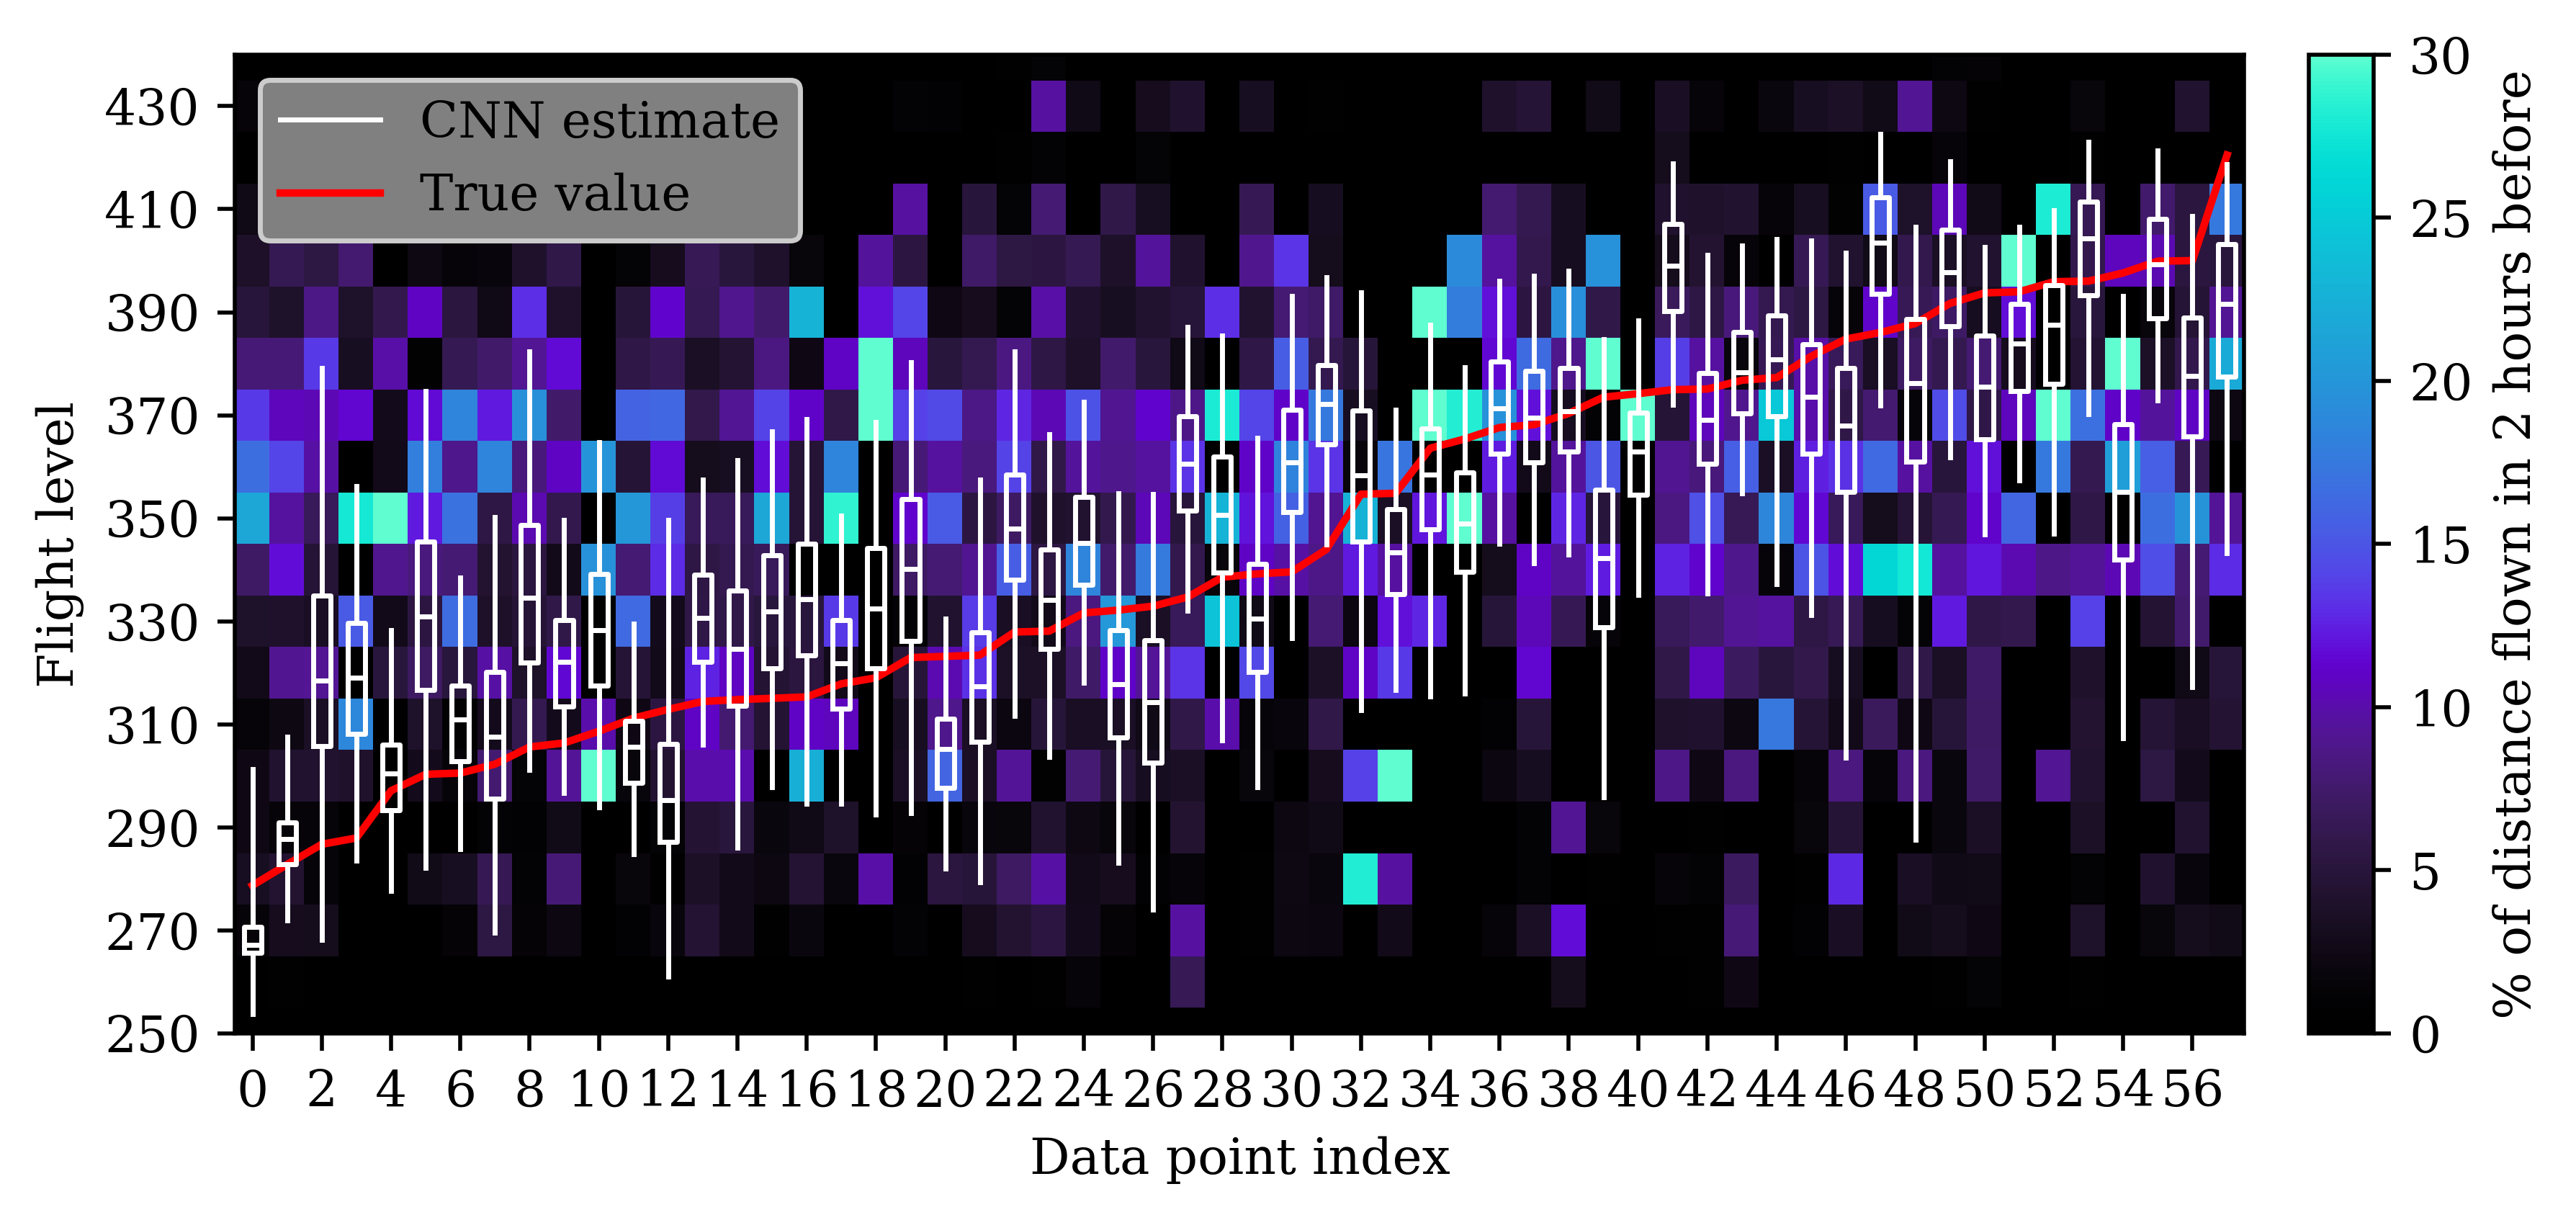

In [7]:
fig, ax = plt.subplots(dpi=500, figsize=(7.2, 7.2 * 0.5))


n = len(ordered_true_values)
vmin = 0
vmax = 30
cf = ax.imshow(img[::-1,:], extent=(0, img.shape[1], 245, 445), vmin=vmin, vmax=vmax, cmap=colormaps.cosmic)
counter = 0

# ordered_true_values[-1] -= 5

ls = ax.plot(np.arange(n) + 0.5, ordered_true_values, c='r',
       label="True value")


for _, box in boxes.iterrows():

    bp = ax.bxp([box], positions=[counter+0.5], widths=0.5, boxprops=dict(color="w"), whiskerprops=dict(color="w"),
           medianprops=dict(color='w'), showcaps=False)
          
    counter += 1
    
    

ax.legend([bp["boxes"][0], ls[0]], ["CNN estimate", "True value"],
          facecolor="gray", framealpha=1.0)
    
    
ax.set_aspect("auto")

ax.set_xlim(0, img.shape[1])
ax.set_xticks(np.arange(0,len(boxes), 2)+0.5)
ax.set_xticklabels(np.arange(0,len(boxes), 2))
ax.set_ylim(250, 440)
ax.set_yticks(np.arange(250, 450, 20))
ax.set(xlabel="Data point index", ylabel="Flight level")

pos = ax.get_position()
cax = fig.add_axes([pos.x1+0.025, pos.y0, 0.025, pos.y1-pos.y0])

plt.colorbar(cf, cax=cax, label='% of distance flown in 2 hours before')